## Case 4

In this case study, we deal with **every 15 minutes prediction**. We will use 3 types of deep learning models to forecast an ICU adult patient's blood culture test results.
Input

> * ICU adults' vital signs and lab results in minutes

Output 

> * 3 categories of blood culture status -- positive / negative / no blood culture
> * label : positive VS negative + no blood culture

Classification strategy
> * summarize/use a certain length of per-minute inputs to every 15 minutes record since admission
> * train, test datasets split by subject

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

## setup

In [2]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp'

In [3]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.


{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id'],
  'label': 'unique subject id for current study',
  'unique_per_sbj': True},
 '__time': {'src_names': ['tsa', 'tsa', 'timeMinutes', 'timeMinutes'],
  'label': 'time since admission',
  'unit': 'minute'},
 '__anchor': {'src_names': ['True_positive', 'True positive'],
  'label': 'anchor for an episode',
  'unique_per_sbj': False,
  'factor': {'levels': {'__neg_nbc': ['0', '0.0', 'nan'],
    '__pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': '__neg_nbc'}}},
 'y': {'output': True,
  'src_names': ['True_positive', 'True positive'],
  'label': 'Event outcome result',
  'unique_per_sbj': False,
  'factor': {'levels': {'nbc': ['nan'],
    'neg': ['0', '0.0'],
    'pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': 'nbc'}}},
 'txp': {'input': True,
  'src_names': ['Confirmed Txp'],
  'label': 'Transplant recipient',
  'unique_per_sbj': True,
  'factor': {'levels': {'no': ['0', '0.0', 'nan'], 'yes': ['1', '1.0']},
   

## Define Episode

In [4]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=1, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

Success! Engineer has updated attributes --- episode. 


In [5]:
print(bsi_stream.engineer.episode)

 
An episode is defined to 
--- use 2880 minute(s) long input variables 
--- predict 1 minute(s) response variables into the future
--- lag 0 minute(s) between predictors and responses
--- increase by every 60 minute(s)
--- last at most 10080 minute(s) long


## Build MVTS (multi-variable time series) data objects
- train_df_imputed, valid_df_imputed and test_df_imputed are dataframes
- train_tfds, valid_tfds and test_tfds are tensorflow datasets

In [6]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 30, # number of subjects / patients to sample from the pool 
                              replace=False, # sample with replacement or not 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median' )# imputation on response (no need in BSI project)

# please see the end of console 
# --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

Engineer is sampling without replacement --- 
30---out of---5671---subjects are sampled from csv pool of size---26093
--- fix upper boundary for age by nan
--- fix lower boundary for age by nan
--- fix upper boundary for temp by nan
--- fix lower boundary for temp by nan
--- fix upper boundary for heart_rate by nan
--- fix lower boundary for heart_rate by nan
--- fix upper boundary for resp_rate by nan
--- fix lower boundary for resp_rate by nan
--- fix upper boundary for spo2 by nan
--- fix lower boundary for spo2 by nan
--- fix upper boundary for x_hr_rr by nan
--- fix lower boundary for x_hr_rr by nan
--- fix upper boundary for s_hr by nan
--- fix lower boundary for s_hr by nan
--- fix upper boundary for s_rr by nan
--- fix lower boundary for s_rr by nan
--- fix upper boundary for s_so2 by nan
--- fix lower boundary for s_so2 by nan
--- fix upper boundary for systolic_blood_pressure by 243.0
--- fix lower boundary for systolic_blood_pressure by 40.0
--- fix upper boundary for diasto

Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 


### print all the attributes of the engineer

In [7]:
print(bsi_stream.engineer)


------------------ episode definition --------------

 
An episode is defined to 
--- use 2880 minute(s) long input variables 
--- predict 1 minute(s) response variables into the future
--- lag 0 minute(s) between predictors and responses
--- increase by every 60 minute(s)
--- last at most 10080 minute(s) long

------------------ sampling info --------------

30---out of---5671---subjects are sampled from csv pool of size---26093

----------------------------- Engineer Attributes List ------------------------

['work_dir', 'meta_dir', 'variable_dict', 'csv_source_dict', 'sql_source_dict', 'input_vars', 'output_vars', 'episode', 'sample_info', 'sample_replace', 'mvts_df', 'mvts_tfds', 'train_df', 'valid_df', 'test_df', 'train_df_imputed', 'valid_df_imputed', 'test_df_imputed', 'train_tfds', 'valid_tfds', 'test_tfds', 'df_csv_fullname_ls']

------------------------------------- Inputs  --------------------------------- 

['txp___yes', 'txp___no', 'age___vital', 'temp___vital', 'heart_ra

## Modeling

In [10]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
]
    

train_tfds = bsi_stream.engineer.train_tfds
valid_tfds =  bsi_stream.engineer.valid_tfds
test_tfds = bsi_stream.engineer.test_tfds


train_tfds = train_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
valid_tfds = valid_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
test_tfds = test_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))


keras.backend.clear_session()
input_shape = list(train_tfds.element_spec[0].shape)[1:3]
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2400)              0         
                                                                 
 batch_normalization (BatchN  (None, 2400)             9600      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4802      
                                                                 
Total params: 14,402
Trainable params: 9,602
Non-trainable params: 4,800
_________________________________________________________________
Epoch 1/100
72/72 [==============================] - 2s 10ms/step - loss: 0.3187 - AUROC: 0.6961 - AUPRC: 0.7600 - val_loss: 0.8175 - val_AUROC: 0.6341 - val_AUPRC: 0.6505
Epoch 2/100
72/72 [==============================] - 0s 4ms/step - loss: 0.

## 10 fold bootstrap

In [ ]:
eval_df_trace_folds = pd.DataFrame()
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
]
# all subjects
for i in range(10):
    
    bsi_stream.engineer.BuildMVTS(csv_pool_path, nsbj=1000, valid_frac=0.2, test_frac=0, batch_size=32, impute_input='median', impute_output='median')
    train_tfds = bsi_stream.engineer.train_tfds
    valid_tfds = bsi_stream.engineer.valid_tfds
    
    train_tfds = train_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
    valid_tfds = valid_tfds.map(lambda x, y: (x, tf.reshape(y, [-1, 2])))
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
    mdl = keras.models.Sequential([
        keras.layers.Flatten(input_shape=input_shape),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(2, activation='softmax')
    ])
    mdl.summary()

    # compile and run the model
    mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=1e-3), metrics = myMetrics)
    callback = EarlyStopping(monitor='val_loss', patience=10)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-5)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    
    keras.backend.set_value(mdl.optimizer.learning_rate, 1e-6)
    his = mdl.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    
    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)
    

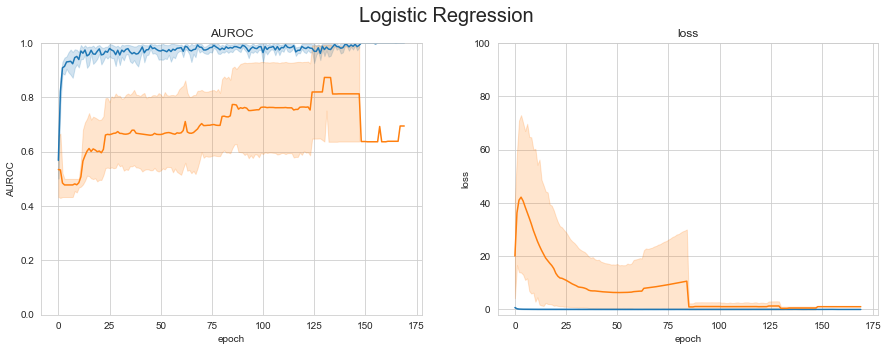

In [19]:
#eval_df_trace_folds.to_csv(work_dir+'/eval_mtrx.csv', index=False)
#data = pd.read_csv(work_dir+'/eval_mtrx.csv')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Logistic Regression', fontsize=20)
axs = axs.flatten()
mtrx = 'AUROC'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[0])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[0])
axs[0].set_ylabel(mtrx)
axs[0].set_ylim(0,1)
axs[0].set_title(mtrx)
mtrx = 'loss'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[1])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[1])
axs[1].set_ylabel(mtrx)
axs[1].set_ylim(-2,100)
axs[1].set_title(mtrx)
plt.show();

# CNN + heatmap

In [ ]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 10000, # number of subjects / patients to sample from the pool 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median' )# imputation on response (no need in BSI project)

# please see the end of console 
# --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

In [55]:
#X_train, Y_train, X_valid, Y_valid, X_test, Y_test = bsi_stream.engineer.ExtractXY()

In [56]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[2])
Y_valid = Y_valid.reshape(Y_valid.shape[0], Y_valid.shape[2])
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[2])

X_all = np.concatenate((X_train, X_valid, X_test), axis=0)
Y_all = np.concatenate((Y_train, Y_valid, Y_test), axis=0)

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)

X_train shape (23508, 96, 25, 1)
Y_train shape (23508, 2)
X_valid shape (6357, 96, 25, 1)
Y_valid shape (6357, 2)
X_test shape (3455, 96, 25, 1)
Y_test shape (3455, 2)
X_all shape (33320, 96, 25, 1)
Y_all shape (33320, 2)


In [57]:
np.save("./X_train.npy", X_train)
np.save("./Y_train.npy", Y_train)
np.save("./X_valid.npy", X_valid)
np.save("./Y_valid.npy", Y_valid)
np.save("./X_test.npy", X_test)
np.save("./Y_test.npy", Y_test)
np.save("./X_all.npy", X_all)
np.save("./Y_all.npy", Y_all)

In [58]:
X_all = np.load("./X_all.npy")
Y_all = np.load("./Y_all.npy")
X_train = np.load("./X_train.npy")
Y_train = np.load("./Y_train.npy")
X_valid = np.load("./X_valid.npy")
Y_valid = np.load("./Y_valid.npy")
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")